In [1]:
import os
import keras
import matplotlib.style as style
import numpy as np
import tables
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from keras import optimizers
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Using TensorFlow backend.


In [2]:
ROOT1 = 'leapgestrecog'
ROOT2 = 'frames'


In [3]:
labels = ['palm', 'fist', 'ok', 'l']

In [4]:

def get_path(ROOT1):
    path = []
    y = []
    for roots, dir_, files in os.walk(ROOT1):
        base = os.path.basename(roots).split('_')
        if len(base) >=2:
            if base[1] in labels:
                for file in files:
                    y.append(base[1])
                    path_name = roots + '/' + file
                    path.append(path_name)
    return path, y

In [5]:
path, y = get_path(ROOT1)
print(len(path), len(y))

12000 12000


In [6]:
path[-5], y[-5]

('leapgestrecog/leapGestRecog/09/07_ok/frame_09_07_0156.png', 'ok')

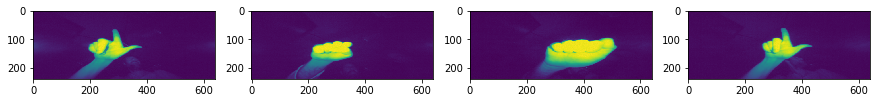

In [7]:
import matplotlib.pyplot as plt

def plot_img(row, col, data):
    
    plt.figure(figsize=(15,15))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        idx = np.random.randint(len(data))
        img = Image.open(data[idx])
        plt.imshow(img)

plot_img(1, 4, path[:5:-1])

In [8]:
def process_image(path):
    X_data = []
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.flip(img, 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
    ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh = cv2.resize(thresh, (224, 224))
    thresh = np.array(thresh)
    X_data.append(thresh)
    
    return X_data



In [9]:
img_list = []
for i in path:
    img_list.append(process_image(i))

print(len(img_list))

12000


In [10]:
len(img_list)

12000

In [11]:
img_list[0][0].shape

(224, 224)

In [12]:
def process_data(X_data):
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    X_data = np.squeeze(X_data, 0)

    return X_data

In [13]:
pre_list = []
for i in img_list:
    new = process_data(i)
    pre_list.append(new)

In [14]:
print(len(pre_list))

12000


In [41]:
a = pre_list
a = np.array(a)
a.shape

(12000, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


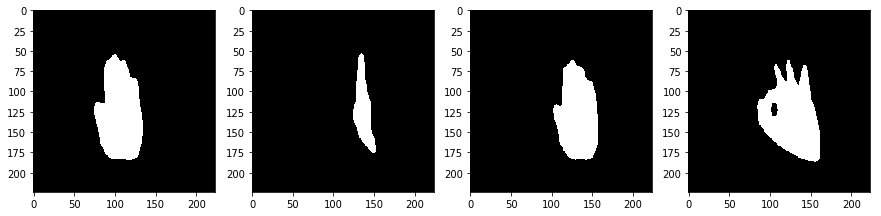

In [16]:
row = 1
col = 4
plt.figure(figsize=(15,15))
for i in range(row*col):
    plt.subplot(row, col, i+1)
    idx = np.random.randint(len(pre_list))
    plt.imshow(pre_list[idx])

In [17]:
new = []
y_new = []
for roots, dir_, files in os.walk(ROOT2):
    for file in files:
#         print(file)
        label = file.split('_')[0]
        if label in labels:
            y_new.append(label)
            path_name = roots + '/' + file
            new.append(path_name)

print(len(new), len(y_new))

1099 1099


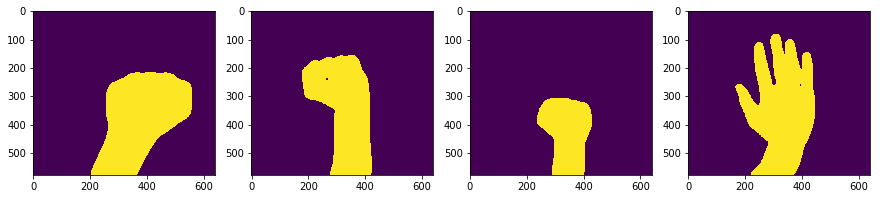

In [18]:
plot_img(1, 4, new)

In [46]:
new_list = []
for i in new:
    new = process_image(i)
    new_list.append(new)

In [48]:
b = new_list
b = np.array(b)
b.shape

(1099, 1, 224, 224)

In [49]:
pre_new = []
for i in new_list:
    new = process_data(i)
    pre_new.append(new)

In [50]:
b = pre_new
b = np.array(b)
b.shape

(1099, 224, 224, 3)

In [51]:
full_list = pre_list + pre_new
y_full = y + y_new

print(len(full_list), len(y_full))

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [52]:
print(len(full_list), len(y_full))

13099 13099


In [58]:
def process_np(X, y):
    encode = LabelEncoder()
    y = encode.fit_transform(y)
    y = to_categorical(y)
    y = np.array(y)
    X = np.array(X)
    return X, y

In [59]:
X, y = process_np(full_list, y_full)

In [60]:
y.shape, X.shape

((13099, 4), (13099, 224, 224, 3))

## TRAIN_TEST_SPLIT

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12, stratify=y)

In [63]:
X_train.shape, y_train.shape

((9169, 224, 224, 3), (9169, 4))

##  VGG based model

In [64]:
file_path = './models/saved_model.hdf5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)


In [4]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
optimizer1 = optimizers.Adam()

base_model = vgg_base  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [69]:


# Train top layers only
for layer in base_model.layers:
    layer.trainable = False

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=8, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1,
          callbacks=[early_stopping, model_checkpoint])


Train on 7335 samples, validate on 1834 samples
Epoch 1/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.5874 - accuracy: 0.9185 - val_loss: 0.0188 - val_accuracy: 0.9956
Epoch 2/10
  64/7335 [..............................] - ETA: 12s - loss: 3.2345e-04 - accuracy: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,accuracy,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


7335/7335 [==============================] - 16s 2ms/step - loss: 0.0269 - accuracy: 0.9950 - val_loss: 0.0115 - val_accuracy: 0.9978
Epoch 3/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.0283 - accuracy: 0.9943 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 4/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.0178 - accuracy: 0.9970 - val_loss: 0.0030 - val_accuracy: 0.9989
Epoch 5/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.0286 - accuracy: 0.9967 - val_loss: 1.2297e-04 - val_accuracy: 1.0000
Epoch 6/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.0185 - accuracy: 0.9978 - val_loss: 0.0047 - val_accuracy: 0.9989
Epoch 7/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0053 - val_accuracy: 0.9989
Epoch 8/10
7335/7335 [==============================] - 17s 2ms/step - loss: 0.0080 - accuracy: 0.9988 - val_loss: 0.0066 - val_accuracy:

In [70]:
model.save('models/basedVCG.h5')

## Model from scratch

In [2]:
scratch = models.Sequential()
scratch.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
scratch.add(layers.MaxPooling2D((2, 2)))
scratch.add(layers.Conv2D(64, (3, 3), activation='relu'))
scratch.add(layers.MaxPooling2D((2, 2)))
scratch.add(layers.Conv2D(64, (3, 3), activation='relu'))
scratch.add(layers.MaxPooling2D((2, 2)))
scratch.add(layers.Flatten())
scratch.add(layers.Dense(128, activation='relu'))
scratch.add(layers.Dense(128, activation='relu'))
scratch.add(layers.Dense(128, activation='relu'))
scratch.add(Dropout(0.25, seed=21))
scratch.add(layers.Dense(4, activation='softmax'))

In [3]:
scratch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)             

In [77]:
scratch.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

scratch.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Train on 7335 samples, validate on 1834 samples
Epoch 1/5
7335/7335 [==============================] - 49s 7ms/step - loss: 0.7081 - accuracy: 0.8769 - val_loss: 0.0400 - val_accuracy: 0.9891
Epoch 2/5
7335/7335 [==============================] - 5s 748us/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0288 - val_accuracy: 0.9935
Epoch 3/5
7335/7335 [==============================] - 5s 739us/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0297 - val_accuracy: 0.9940
Epoch 4/5
7335/7335 [==============================] - 5s 727us/step - loss: 0.0164 - accuracy: 0.9960 - val_loss: 0.0200 - val_accuracy: 0.9956
Epoch 5/5
7335/7335 [==============================] - 5s 732us/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0328 - val_accuracy: 0.9956


## Classification metrics

In [89]:
def get_classification_metrics(X_test, y_test, model):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))
    
    return confusion_matrix(y_true, pred)

In [90]:
matrix_model = get_classification_metrics(X_test, y_test, model)

[[1365    0    0    0]
 [   0  600    0    0]
 [   0    0  600    0]
 [   2    0    0 1363]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1365
          1       1.00      1.00      1.00       600
          2       1.00      1.00      1.00       600
          3       1.00      1.00      1.00      1365

avg / total       1.00      1.00      1.00      3930



In [91]:
matrix_VCG = get_classification_metrics(X_test, y_test, VCG)

[[1362    0    0    3]
 [   0  600    0    0]
 [   0    0  600    0]
 [   1    1    0 1363]]


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1365
          1       1.00      1.00      1.00       600
          2       1.00      1.00      1.00       600
          3       1.00      1.00      1.00      1365

avg / total       1.00      1.00      1.00      3930



In [92]:
matrix_scratch = get_classification_metrics(X_test, y_test, scratch)

[[1363    1    0    1]
 [   0  600    0    0]
 [   0    0  600    0]
 [  15    0    1 1349]]


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1365
          1       1.00      1.00      1.00       600
          2       1.00      1.00      1.00       600
          3       1.00      0.99      0.99      1365

avg / total       1.00      1.00      1.00      3930



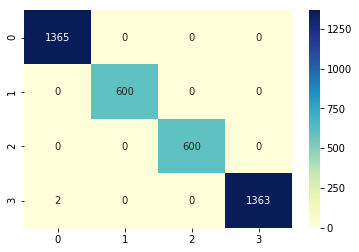

In [93]:
import seaborn as sns
sns.heatmap(matrix_model, annot=True,  fmt='d',  cmap="YlGnBu")

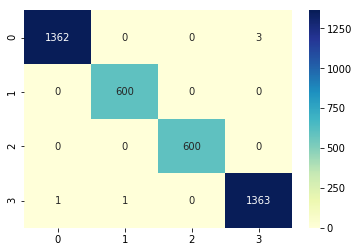

In [94]:
sns.heatmap(matrix_VCG, annot=True,  fmt='d',  cmap="YlGnBu")

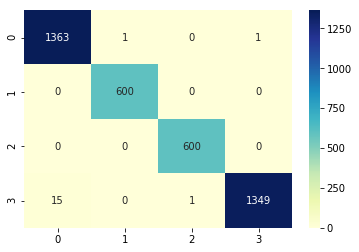

In [95]:
sns.heatmap(matrix_scratch, annot=True,  fmt='d',  cmap="YlGnBu")